In [1]:
import cv2

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import skimage
import sunpy.cm as cm

from matplotlib.colors import SymLogNorm
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from astropy.io import fits
from sunpy.map import Map
from astropy import units as u

import torch
import math

from google.cloud import storage
import dask.bytes

from metrics_gradient import  * #Grad_Sobel

from torch.utils.data import DataLoader, Subset
from dataset import BaseDataset, MagDataset, GoogleDataset
from astropy.coordinates import SkyCoord
# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

import pandas as pd

# Color Axis limits
vmin = -2000
vmax = 2000

In [2]:
client = storage.Client()

In [3]:
files = dask.bytes.open_files('gcs://fdl-mag-sdo/2010/04/07/hmi.M_720s.20100407_013600_TAI.1.magnetogram.fits')[0:1]
# files = dask.bytes.open_files('gcs://fdl-mag-sdo/2014/05/**/*.fits')[0:1]

In [4]:
#client = storage.Client()
#files = dask.bytes.open_files('gcs://fdl-mag-sdo/2014/05/**/*.fits')[0:1]
for handle in files:
    with handle as file:
        print(handle.path)
        print(file)
        hdul = fits.open(file, cache=False)
        hdul.verify('fix')
        hmi_map = Map(hdul[1].data, hdul[1].header)
#        hmi_map.peek()
        rot_map = hmi_map#.rotate(rmatrix=rot_map.rotation_matrix, recenter = True)      
#        rot_map.peek(norm=SymLogNorm(0.1))
wdth =190
# wdth =2000
# test = rot_map.submap((2048-wdth/2, 2048+wdth/2)*u.pix, (2048+wdth/2,2048-wdth/2)*u.pix)
bottom_left_coord = SkyCoord(-wdth/2*rot_map.meta['cdelt1']*u.arcsec, -wdth/2*rot_map.meta['cdelt1']*u.arcsec, frame=rot_map.coordinate_frame)
top_right_coord = SkyCoord(wdth/2*rot_map.meta['cdelt1']*u.arcsec, wdth/2*rot_map.meta['cdelt1']*u.arcsec, frame=rot_map.coordinate_frame)
test = rot_map.submap(bottom_left_coord, top_right_coord)

fdl-mag-sdo/2010/04/07/hmi.M_720s.20100407_013600_TAI.1.magnetogram.fits
<GCSFile fdl-mag-sdo/2010/04/07/hmi.M_720s.20100407_013600_TAI.1.magnetogram.fits>


 [astropy.io.fits.verify]


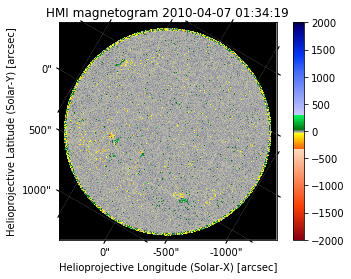

In [5]:
rot_map.peek(cmap = current_cmap, vmin= vmin, vmax=vmax)

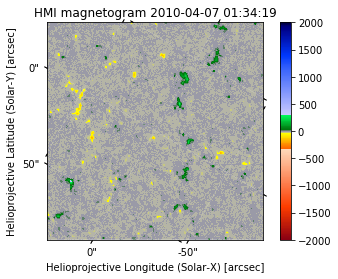

In [6]:
test.peek(cmap = current_cmap, vmin= vmin, vmax=vmax)

In [7]:
conversion = {'input': 'LR', 'target': 'HR'}
dset_test = GoogleDataset('index.csv', 'fdl-mag-sandbox', client, conversion, np.arange(0,1))

In [8]:
test_loader = DataLoader(dset_test,batch_size=1) #, sampler=SequentialSampler(test_indices))

torch.Size([1, 256, 256])


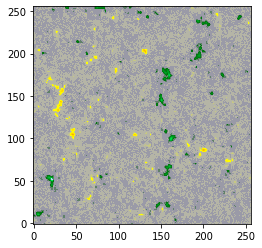

In [9]:
for iteration, batch in enumerate(test_loader, 1): #enumerate(iterable, start=0 by default)
    input = batch['input'].cpu()
    target = batch['target'].cpu()
    print(target.shape)
#    output = model.forward(input) #output is predict for future name change
#    loss = model.loss(output, target)
#    print(loss)
#    Visualize().visualize_img(output,target,root_dir) #root_dir not being used for bucket
#    #Visualize().visualize_single(output, root_dir)
    plt.imshow(((target[0,:,:])), cmap = current_cmap, vmin= vmin, vmax=vmax, origin='lower')
#    plt.imshow(input[0,:,:], cmap = current_cmap, vmin= vmin, vmax=vmax)
#    t2 = target[0,:,:]

In [10]:
test_loader

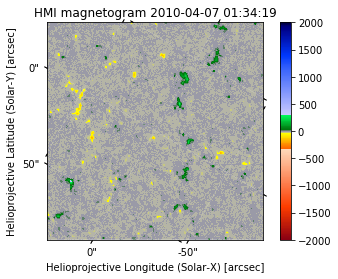

In [11]:
test.peek(cmap = current_cmap, vmin= vmin, vmax=vmax)

In [12]:
hist, edges = np.histogram(test.data, bins='auto')

In [13]:
edges.shape

(1671,)

In [14]:
img = torch.from_numpy(test.data).to(torch.float32)

In [15]:
img_stack = torch.stack([img,img],dim=0)

In [16]:
def avg_kern(size): #size = 3,5,7
    
    K = torch.ones((size,size))
    N = size**2
    
    K = K/N
    
    return K

In [17]:
def entropy(P):
#    print(P)
    entropy = -torch.sum(P*torch.log(P))
    return entropy

In [18]:
entropies = []
entropies_target = []

wdth = 256

W = list(range(1, 150))

x = []
x_t = []



for w in W:
#    print(w)
    conv_layer = torch.nn.Conv2d(1, 1, w, padding=0, stride=w, bias=False)
    conv_layer.weight.data = avg_kern(w)[None,None,]
    conv_img = conv_layer(img[None,None,:,:])
    conv_img_target = conv_layer(target[:,None,:,:])

#    print(conv_img)
    P = torch.histc(conv_img, bins=2**16, min = -700, max = 700) #min=conv_img.min().data, max=conv_img.max().data)
    P += 1e-6
#    print(P.sum())
    P = P / P.sum()   
    
    x.append(int(img.shape[0]/w**2)) #shape[2]
    
    H = entropy(P.float())
#    print(H)
    entropies.append(H.detach().numpy())  
    
#    print(conv_img)
    P_t = torch.histc(conv_img_target, bins=2**16, min = -700, max = 700) #min=conv_img.min().data, max=conv_img.max().data)
    P_t += 1e-6
#    print(P.sum())
    P_t = P_t / P_t.sum()   
    
    x_t.append(int(target.shape[0]/w**2)) #shape[2]
    
    H_t = entropy(P_t.float())
#    print(H)
    entropies_target.append(H_t.detach().numpy())  

In [22]:
class GaussianHistogram(nn.Module):
    def __init__(self, bins, min, max, sigma):
        super(GaussianHistogram, self).__init__()
        self.bins = bins
        self.min = min
        self.max = max
        self.sigma = sigma
        self.delta = float(max - min) / float(bins)
        self.centers = float(min) + self.delta * (torch.arange(bins).float() + 0.5)

    def forward(self, x):
        x = torch.unsqueeze(x, 0) - torch.unsqueeze(self.centers, 1)
        x = torch.exp(-0.5*(x/self.sigma)**2) / (self.sigma * np.sqrt(np.pi*2)) * self.delta
        x = x.sum(dim=1)
        return x

In [46]:
img.shape

torch.Size([260, 259])

In [ ]:
data = 700  * torch.randn(1000)

hist = torch.histc(img.view(-1), bins=10000, min = -700, max = 700)

#print(hist)

gausshist = GaussianHistogram(bins=10000, min = -700, max = 700, sigma=0.5)


data.requires_grad = True
gauss_hist = gausshist(img.view(-1))
#print(gauss_hist)

#hist.sum().backward()
#print(data.grad)

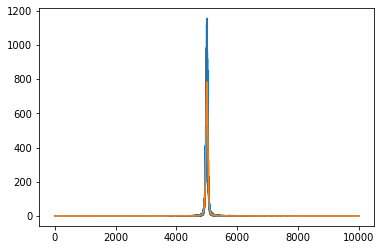

In [57]:
plt.plot(hist.detach().numpy())
plt.plot(gauss_hist.detach().numpy())

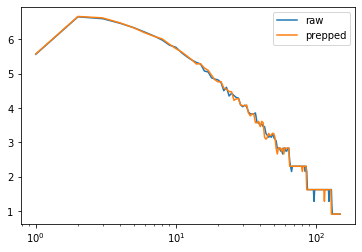

In [19]:
fig, ax = plt.subplots()
ax.plot(np.array(W), entropies,label="raw")
ax.plot(np.array(W), entropies_target, label="prepped")
plt.legend()
# ax.set_xlim(left=0, right=5)
ax.set_xscale('log')

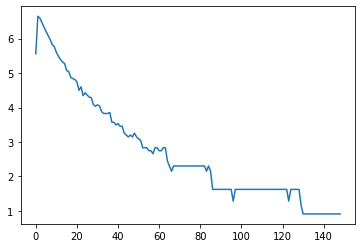

In [20]:
plt.plot(entropies)

In [21]:
entropies2 = []

W2 = list(range(1, 256))

x2 = []

for w2 in W2:
#    print(w2)
    conv_layer = torch.nn.Conv2d(1, 1, w2, padding=0, stride=w2, bias=False)
    conv_layer.weight.data = avg_kern(w2)[None,None,]
    conv_img2 = conv_layer(img_stack2[:,None,:,:])
#    print(conv_img)
    P2 = torch.histc(conv_img2, bins=2**16, min = -700, max = 700) #min=conv_img.min().data, max=conv_img.max().data)
    P2 += 1e-6
#    print(P.sum())
    P2 = P2 / P2.sum()   
    
    x2.append(int(img2.shape[0]/w**2)) #shape[2]
    
    H2 = entropy(P2.float())
#    print(H)
    entropies2.append(H2.detach().numpy()) 

NameError: name 'img_stack2' is not defined

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(x2, entropies2)